In [1]:
path = '../data/'

In [2]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
%matplotlib inline

In [3]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

## Data Cleaning (syntactic)

In [4]:
df_sds011.shape, df_dht22.shape

((739843, 14), (743179, 10))

In [5]:
print(df_sds011.columns)
print(df_sds011.dtypes)
print(df_dht22.columns)
print(df_dht22.dtypes)

Index(['sensor_id', 'sensor_type', 'location', 'lat', 'lon', 'timestamp', 'P1',
       'durP1', 'ratioP1', 'P2', 'durP2', 'ratioP2', 'filepath', 'filename'],
      dtype='object')
sensor_id        int64
sensor_type     object
location         int64
lat            float64
lon            float64
timestamp       object
P1             float64
durP1          float64
ratioP1        float64
P2             float64
durP2          float64
ratioP2        float64
filepath        object
filename        object
dtype: object
Index(['sensor_id', 'sensor_type', 'location', 'lat', 'lon', 'timestamp',
       'temperature', 'humidity', 'filepath', 'filename'],
      dtype='object')
sensor_id        int64
sensor_type     object
location         int64
lat            float64
lon            float64
timestamp       object
temperature    float64
humidity       float64
filepath        object
filename        object
dtype: object


### Convert to date time

In [6]:
df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')

In [133]:
df_sds011.describe()

,sensor_id,location,lat,lon,P1,P2
count,739830.000000,739830.000000,739830.000000,739830.000000,739830.000000,739830.000000
mean,8906.291232,4503.683591,52.508128,13.281754,26.867686,15.718154
std,3572.105009,1809.158781,0.001974,0.020278,31.916247,17.506133
min,6179.000000,3123.000000,52.506000,13.256000,0.000000,0.000000
25%,6179.000000,3123.000000,52.506000,13.256000,6.920000,3.800000
50%,7201.000000,3642.000000,52.508000,13.285000,14.130000,8.330000
75%,12603.000000,6367.000000,52.509000,13.303000,35.530000,21.200000
max,17231.000000,8732.000000,52.513000,13.303000,1999.900000,564.800000


In [ ]:
df_dht22.describe()

In [92]:
df_sds011.groupby(['sensor_id', 'location']).count()

,,sensor_type,lat,lon,timestamp,P1,P2
sensor_id,location,,,,,,
6179,3123,264096,264096,264096,264096,264096,264096
7201,3642,248374,248374,248374,248374,248374,248374
12603,6367,161817,161817,161817,161817,161817,161817
17231,8732,65543,65543,65543,65543,65543,65543


In [89]:
df_dht22.groupby(['sensor_id', 'location']).count()

,,sensor_type,lat,lon,timestamp,temperature,humidity,filepath,filename
sensor_id,location,,,,,,,,
6180,3123,266982,266982,266982,266982,266982,266982,266982,266982
7202,3642,248466,248466,248466,248466,248466,248466,248466,248466
12604,6367,162158,162158,162158,162158,162158,162158,162158,162158
17232,8732,65560,65560,65560,65560,65560,65560,65560,65560
20827,10574,13,13,13,13,13,13,13,13


### Dropping

In [8]:
df_sds011 = df_sds011[['sensor_type', 'location', 'timestamp', 'P1', 'P2']]
df_dht22 = df_dht22[['sensor_type', 'location', 'timestamp', 'temperature', 'humidity']]

In [307]:
df_sds011.isnull().sum()

sensor_type    0
location       0
timestamp      0
P1             0
P2             0
dtype: int64

In [308]:
df_dht22.isnull().sum()

sensor_type    0
location       0
timestamp      0
temperature    0
humidity       0
dtype: int64

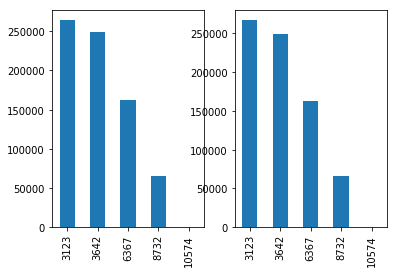

In [9]:

fig, axes = plt.subplots(nrows=1, ncols=2)

df_sds011['location'].value_counts().plot.bar(ax=axes[0])
df_dht22['location'].value_counts().plot.bar(ax=axes[1])

In [317]:
#droping location with to few samples

df_sds011 = df_sds011[df_sds011.location != 10574]
df_dht22 = df_dht22[df_dht22.location != 10574]

## Data Cleaning (semantic)

First set resample into a 1 min resolution filter merge dht with sds and the set resolution to 30 or 60min.
But first some humidity plots for all locations


99.9

In [18]:
def plot(df, col, fig=None, ax=None, idx=None):
    
    upper = 70#50
    lower = 0#20
    
    if df.index.dtype != '<M8[ns]':
        df = df.set_index(df.timestamp)

    s = df[col]
    t = df.index

    supper = np.ma.masked_where(s < upper, s)
    slower = np.ma.masked_where(s > lower, s)
    smiddle = np.ma.masked_where(np.logical_or(s < lower, s > upper), s)

    q3 = s.quantile(.75)
    q1 = s.quantile(.25)
    
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr # mild outlier
    fence_high = q3+1.5*iqr # mild outlier
    
    print('Q3', q3, 'Q1', q1, 'fence_low', fence_low, 'fence_high', fence_high)
    
    if ax:
        ax.plot(t, smiddle, 'green', t, slower, 'red', t, supper, 'red')
        ax.hlines(y=fence_high, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')
        ax.hlines(y=fence_low, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
        axes.plot(t, smiddle, 'green', t, slower, 'red', t, supper, 'red')
        axes.hlines(y=fence_high, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')
        axes.hlines(y=fence_low, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')
    

def plot_location(df, col):



    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))



    for idx, (loc, loc_df) in enumerate(df.groupby('location')):
        print(loc)
    
        plot(loc_df, col, fig, axes[idx])

    plt.tight_layout()

In [14]:
def resample(df):
    dfs = [] 

    for loc, loc_df in df.groupby('location'):
        loc_df = loc_df.set_index(loc_df.timestamp)
        loc_df = loc_df.resample('60min').mean()
        dfs.append(loc_df)
    return pd.concat(dfs)


In [13]:
a = resample(df_dht22[df_dht22.location == 6367.0])
b = resample(df_dht22[df_dht22.location == 3642.0])
c = resample(df_dht22[df_dht22.location == 8732.0])


def join(a,b):
    
    ### With inner join many data points will be lost ### CHANGE
    merged = pd.merge(a,b, left_index=True, right_index=True).dropna()
    merged['humidity'] = (merged['humidity_x'] + merged['humidity_y']) / 2 
    merged['temperature'] = (merged['temperature_x'] + merged['temperature_y']) / 2 
    return merged[['humidity', 'temperature']]
    
m = reduce(join, [b,c], a)

NameError: name 'resample' is not defined

3123
Q3 99.9 Q1 99.9 fence_low 99.9 fence_high 99.9
3642
Q3 93.5 Q1 54.9 fence_low -3.000000000000007 fence_high 151.4
6367
Q3 98.4 Q1 44.0 fence_low -37.60000000000001 fence_high 180.0
8732
Q3 84.2 Q1 63.0 fence_low 31.199999999999996 fence_high 116.0


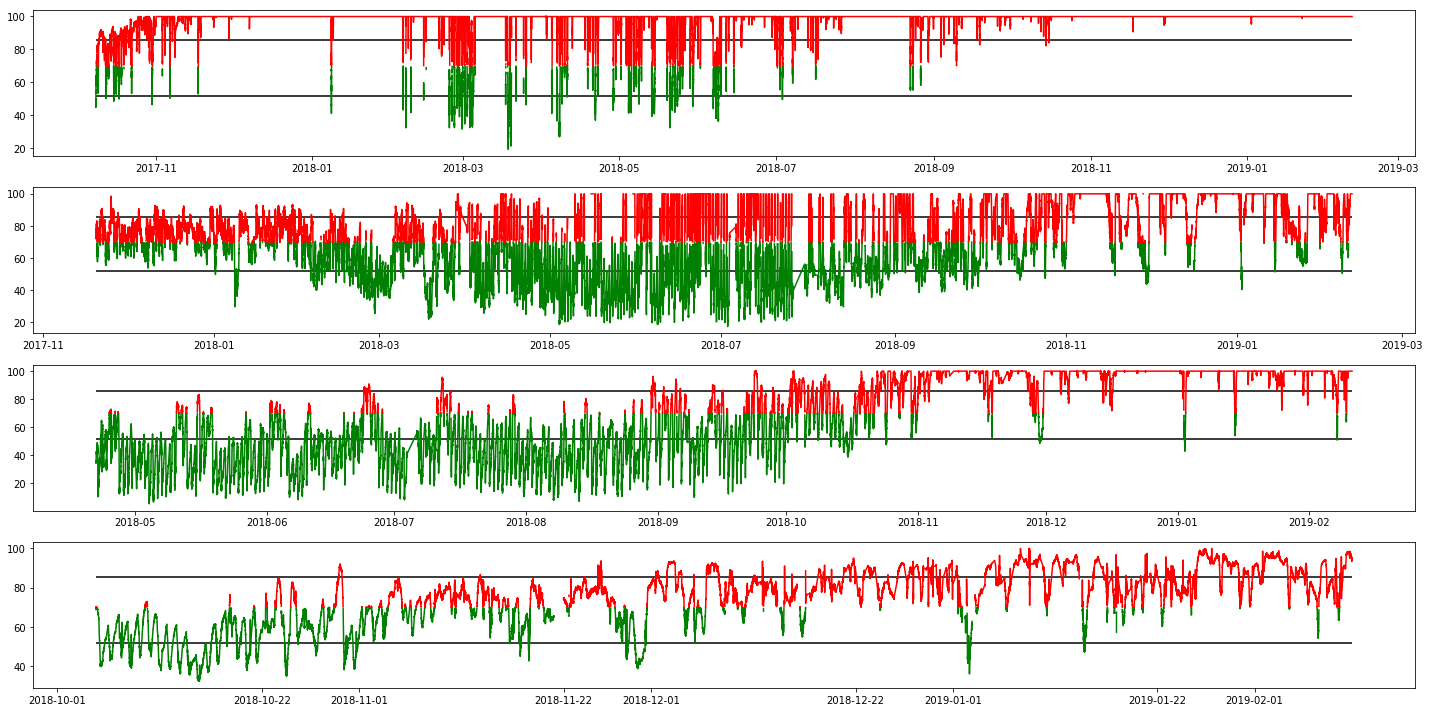

In [287]:

plot_location(df_dht22, 'humidity')

### Merged humidities with on hour resolution

In [292]:
print(df_dht22[['timestamp']].min(), df_dht22[['timestamp']].max())
print(m[['humidity']].index.min(), m[['humidity']].index.max())

timestamp   2017-10-08 14:34:53
dtype: datetime64[ns] timestamp   2019-02-10 23:59:51
dtype: datetime64[ns]
2018-10-04 23:00:00 2019-02-10 23:00:00


            humidity
count  743166.000000
mean       80.143121
std        23.280219
min         5.200000
25%        62.600000
50%        91.300000
75%        99.900000
max        99.900000
Merged
          humidity
count  2686.000000
mean     81.488682
std      13.408606
min      38.441000
25%      74.757705
50%      85.435646
75%      91.188854
max      99.708333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123d704a8>]],
      dtype=object)

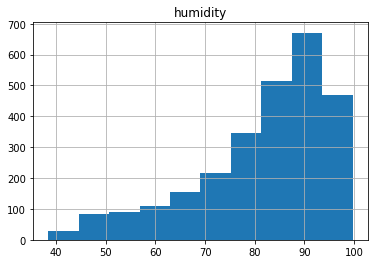

In [290]:


print(df_dht22[['humidity']].describe())
print('Merged')
print(m[['humidity']].describe())

m[['humidity']].hist()

Q3 91.18885416666669 Q1 74.75770509153318 fence_low 50.110981478832926 fence_high 115.83557777936694


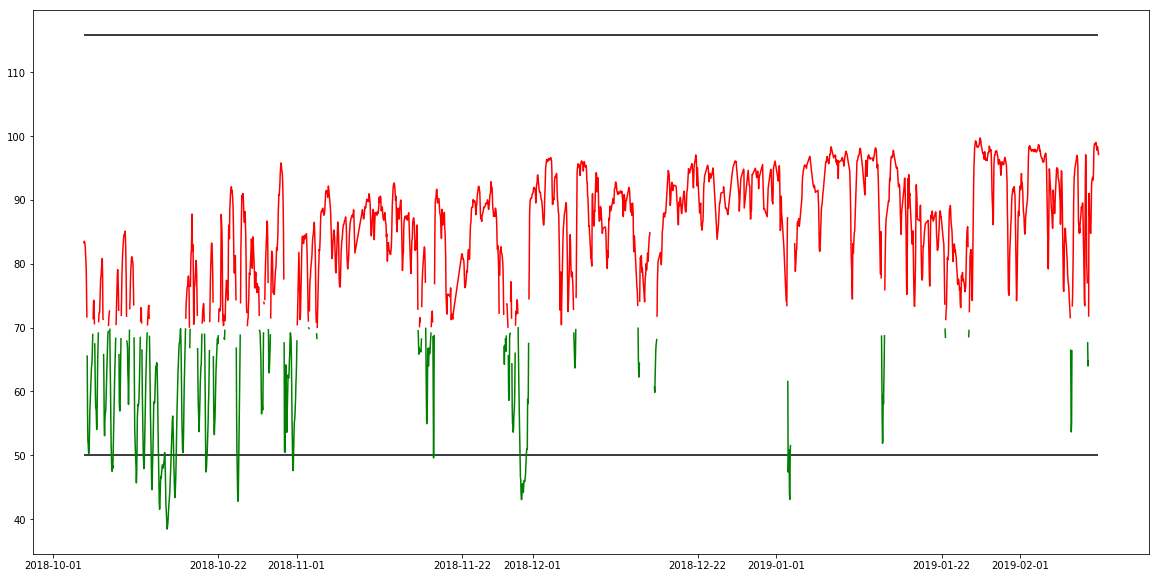

In [276]:
plot(m[['humidity']])

### Outliers 

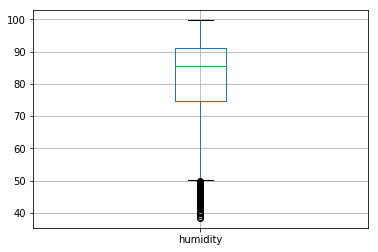

In [277]:
m[['humidity']].boxplot()

### Look at the single humidiy observations and clear data points with over 70% humidity

Absolute data loss: 0.359243
Absolute data loss: 0.703505
(20834, 3)
(9799, 1)


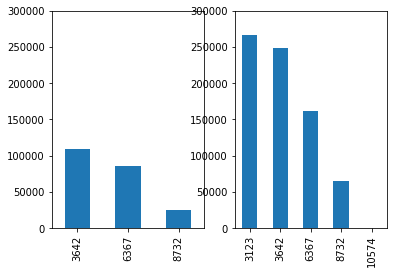

In [86]:
    # dont use sensor at location 3123 --> contains to many 100% humidiy values. either broken or bad sensor placing 
cleared_dht22 = df_dht22[(df_dht22.location != 3123)]

print('Absolute data loss: %f' % (1.0 - (cleared_dht22.shape[0] / df_dht22.shape[0])))


cleared_dht22 = cleared_dht22[cleared_dht22.humidity < 70.0]

print('Absolute data loss: %f' % (1.0 - (cleared_dht22.shape[0] / df_dht22.shape[0])))


fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].set_ylim([0,300000])
axes[1].set_ylim([0,300000])

cleared_dht22['location'].value_counts().plot.bar(ax=axes[0])
df_dht22['location'].value_counts().plot.bar(ax=axes[1])


### TODO look into possible resample bug. why are there so few data points left 
print(resample(cleared_dht22).shape)
print(resample(cleared_dht22).dropna().shape)


                  P1
count  739843.000000
mean       26.867225
std        31.916156
min         0.000000
25%         6.920000
50%        14.130000
75%        35.530000
max      1999.900000
                  P1
count  687968.000000
mean       20.197376
std        18.532326
min         0.000000
25%         6.570000
50%        12.730000
75%        28.170000
max        78.430000
(739843, 7) (687968, 7)


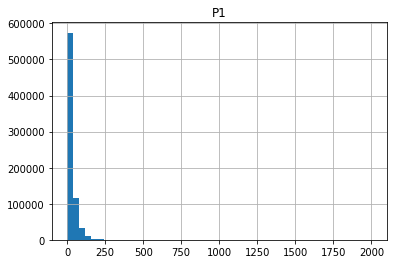

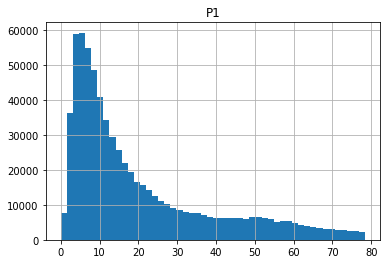

In [78]:
def is_outlier(series):
    q3 = series.quantile(.75)
    q1 = series.quantile(.25)
    
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr # mild outlier
    fence_high = q3+1.5*iqr # mild outlier
    
    return series.between(fence_low, fence_high)

cleared_p1 = df_sds011[is_outlier(df_sds011['P1'])]

print(df_sds011[['P1']].describe())
print(cleared_p1[['P1']].describe())

df_sds011[['P1']].hist(bins=50)
cleared_p1[['P1']].hist(bins=50)

print(df_sds011.shape, cleared_p1.shape)

In [ ]:
cleared_p1

### PM Values

3123
Q3 40.1 Q1 9.87 fence_low -35.47500000000001 fence_high 85.44500000000001
3642
Q3 21.17 Q1 6.0 fence_low -16.755000000000003 fence_high 43.925000000000004
6367
Q3 16.07 Q1 4.6 fence_low -12.605000000000002 fence_high 33.275000000000006
8732
Q3 85.415 Q1 51.57 fence_low 0.8024999999999878 fence_high 136.1825


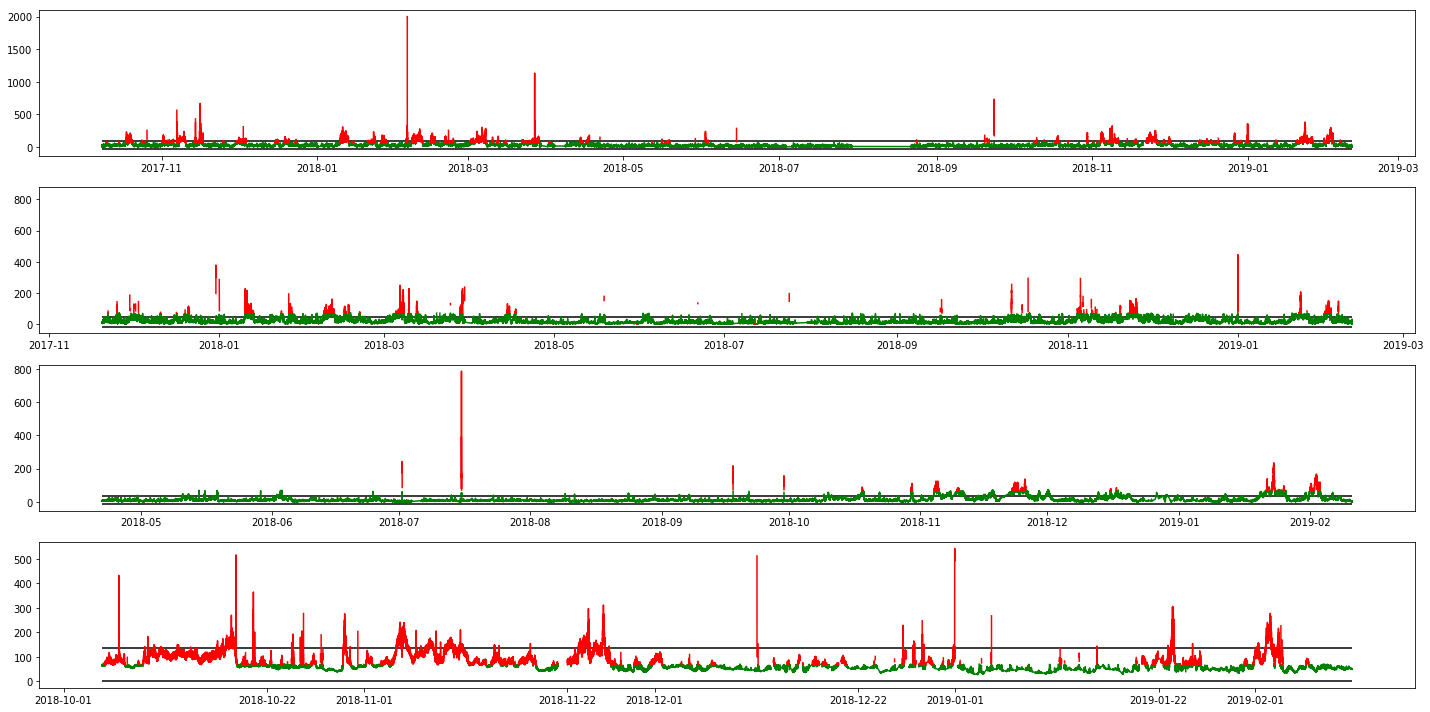

In [295]:
plot_location(df_sds011, 'P1')